# Learning FLPO

In this code, we will implement the hierarchical ML architecture to predict the parameters in the FLPO setup.

In [170]:
import torch
from VRP_Net_L import VRPNet_L
from matplotlib import pyplot as plt
import utils
import os
import matplotlib.pyplot as plt
from torchinfo import summary
import numpy as np
import time
import LSE_net
from torch import optim
import importlib

# Loading the Data

In [171]:
torch.normal(mean=torch.tensor([0.3,0.3]), std=torch.tensor([0.1,0.1]))

tensor([0.2691, 0.4869])

In [187]:

seed=41;
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print("Running on: " , device)
num_drones = 10 # number of FLPO instances
num_facilities = 3
dim_ = 2
# START and END locations: no grads needed
nd_per_cluster = int(num_drones/2)
means1 = torch.tensor([[0.4,0.7]]).repeat(nd_per_cluster,1).unsqueeze(1).to(device)
std1 = torch.tensor([[0.05,0.05]]).repeat(nd_per_cluster,1).unsqueeze(1).to(device)
means2 = torch.tensor([[0.7,0.3]]).repeat(nd_per_cluster,1).unsqueeze(1).to(device)
std2 = torch.tensor([[0.05,0.05]]).repeat(nd_per_cluster,1).unsqueeze(1).to(device)
START_locs1 = torch.normal(mean=means1, std=std1)
START_locs2 = torch.normal(mean=means2, std=std2)
START_locs = torch.cat((START_locs1, START_locs2), axis=0)
END_locs   = torch.ones((num_drones, 1, dim_), requires_grad=False, device=device)#torch.rand(num_drones, 1, dim_, requires_grad=False, device=device)

# Facility locations: we want grads here
# We create a base tensor with requires_grad=True, then expand it
# F_base = torch.rand(1, num_facilities, dim_, requires_grad=True, device=device)
F_base = torch.mean(START_locs, dim=0).repeat(num_facilities, 1).unsqueeze(0).requires_grad_().to(device)
F_locs = F_base.expand(num_drones, -1, -1)  # view, shares grad with F_base
data = torch.cat((START_locs, F_locs, END_locs), dim=1)  # shape: (Nd, Nf+2, D)
print("Data Loaded.")


Running on:  cpu
Data Loaded.


### Compute n_routes from each drone

In [188]:
importlib.reload(utils)
n_drone_routes = torch.tensor(utils.num_flpo_routes(num_facilities, num_drones)[0], dtype=torch.float32).view(-1,1).to(device)
print(f"n_routes:\t{n_drone_routes.shape}\n{n_drone_routes}\nlog_n_routes:\t{n_drone_routes.shape}\n{torch.log(n_drone_routes)}")

n_routes:	torch.Size([10, 1])
tensor([[40.],
        [40.],
        [40.],
        [40.],
        [40.],
        [40.],
        [40.],
        [40.],
        [40.],
        [40.]])
log_n_routes:	torch.Size([10, 1])
tensor([[3.6889],
        [3.6889],
        [3.6889],
        [3.6889],
        [3.6889],
        [3.6889],
        [3.6889],
        [3.6889],
        [3.6889],
        [3.6889]])


# Loading the VRP NET Module

In [189]:
hidden_dim = 32
num_layers_enc = 1
num_layers_dec = 1
num_heads = 8
torch.cuda.empty_cache()
vrp_net = VRPNet_L(dim_, hidden_dim, device, num_layers_enc, num_layers_dec, num_heads)
if torch.cuda.is_available():
    vrp_net.load_state_dict(torch.load('Saved models/POMO2025_04_12 00_54_260.6350972652435303best_model.pth',weights_only=True))
else:
    vrp_net.load_state_dict(torch.load('Saved models/POMO2025_04_12 00_54_260.6350972652435303best_model.pth',weights_only=False, map_location=torch.device('cpu')))
vrp_net.eval()

# for param in vrp_net.parameters():
#     param.requires_grad = False
print('VRP NET loaded on: ',vrp_net.device)
print(summary(vrp_net))

VRP NET loaded on:  cpu
Layer (type:depth-idx)                                                 Param #
VRPNet_L                                                               --
├─LinearAttnEncoder: 1-1                                               2,560
│    └─MultiheadAttention: 2-1                                         197,376
│    │    └─NonDynamicallyQuantizableLinear: 3-1                       65,792
│    └─Linear: 2-2                                                     768
│    └─Linear: 2-3                                                     8,224
│    └─LayerNorm: 2-4                                                  512
│    └─Dropout: 2-5                                                    --
│    └─ReLU: 2-6                                                       --
├─Decoder: 1-2                                                         --
│    └─TransformerDecoder: 2-7                                         --
│    │    └─ModuleList: 3-2                                       

# Loading lseNet

In [190]:
importlib.reload(LSE_net)
lse_data = torch.load('logSumExp_models/lse_2025_4_30__14_6_10.pth', weights_only=False)
n_inputs = lse_data['n_inputs']
n_outputs = lse_data['n_outputs']
layers = lse_data['layers']
weights = lse_data['model_state_dict']
io_scale = lse_data['io_scale']
lse_net = LSE_net.dnn(n_inputs, n_outputs, layers)
lse_net.to(device)
lse_net.load_state_dict(weights)
lse_net.eval()
for p in lse_net.parameters():
    p.requires_grad = False
print(f'n_inputs: {n_inputs}\nn_outputs: {n_outputs}\nlayers: {layers}\nio_scale: {io_scale}\nLSE_net:\n{summary(lse_net)}')

n_inputs: 3
n_outputs: 1
layers: [20, 20, 10]
io_scale: 1
LSE_net:
Layer (type:depth-idx)                   Param #
dnn                                      --
├─ModuleList: 1-1                        --
│    └─Linear: 2-1                       (80)
│    └─ReLU: 2-2                         --
│    └─Linear: 2-3                       (420)
│    └─ReLU: 2-4                         --
│    └─Linear: 2-5                       (210)
│    └─ReLU: 2-6                         --
│    └─Linear: 2-7                       (11)
Total params: 721
Trainable params: 0
Non-trainable params: 721


In [191]:
torch.tensor([10,10]).shape

torch.Size([2])

In [192]:
def logSumExp(D_tensor, beta):
    # with torch.no_grad():
    # print(D_tensor)
    D_min = torch.min(D_tensor, axis=1, keepdims=True)
    F = -1/beta * torch.log(torch.sum(torch.exp(-beta*(D_tensor - D_min.values)), axis=1, keepdims=True)) + 1/beta * torch.log(torch.tensor([D_tensor.shape[1]])) + D_min.values
    return F

def area_approx_F(D_min, D_max_range, beta, printCalculations=False):
    min_beta_D_arr = beta * D_min
    x_max = beta * D_max_range - min_beta_D_arr
    F_est = -1/beta * torch.log(1/x_max * (1 - torch.exp(-x_max))) + D_min
    
    if printCalculations:
        print(f'min_beta_D_arr:{min_beta_D_arr}')
        print(f'x_max:{x_max}')
        print(f'inside_log:{1/x_max * (1 - torch.exp(-x_max))}')
        print(f'log:{torch.log(1/x_max * (1 - torch.exp(-x_max)))}')
        print(f'-1/beta_log:\n{-1/beta * torch.log(1/x_max * (1 - torch.exp(-x_max)))}')
        
    return F_est

### Pick a random variable matrix with iid entries of shape shape (a,b) between [r1, r2] at uniform using pytorch

In [193]:
# a = 3
# b = 2
# r1 = 0.5
# r2 = 10.0
# (r1 - r2) * torch.rand(a,b) + r2

In [194]:
s = time.time()
with torch.no_grad():
    # forward pass: no activations are saved for grad
    _, actions = vrp_net(data, mod='eval_greedy')
e = time.time()
actions.detach()
d_mins = utils.route_cost(data, actions)


#### The next 3 blocks show that, when we work with torch.float32 datatype, the Free energy approximation at $\beta_{min}$ \[using the function area_approx_F()\] is poor when $\beta_{min} \leq 2e-4$. Therefore, for all d_mins $\in [0,1],$ we should keep $\beta_{min} > 1e-3.$

In [195]:
print(d_mins)
print(d_mins.dtype)


tensor([0.4993, 0.5213, 0.5593, 0.5157, 0.4953, 0.5049, 0.5148, 0.5085, 0.5586,
        0.5004], grad_fn=<SumBackward1>)
torch.float32


In [196]:
d_mins1 = d_mins.to(torch.float64)
print(d_mins1)
print(d_mins1.dtype)

tensor([0.4993, 0.5213, 0.5593, 0.5157, 0.4953, 0.5049, 0.5148, 0.5085, 0.5586,
        0.5004], dtype=torch.float64, grad_fn=<ToCopyBackward0>)
torch.float64


#### Theoretically, the estimate of Free Energy at $\beta_{min}$ should be (almost) equal at $\beta = 1e-3$ and $\beta = 1e-4$. Below we observe that when the d_min data is in float32 precision, the values are not equal for the two $\beta$ values.

In [197]:
# discared method using uniform distribution on D's
# with torch.no_grad():
    # D_tensor = (d_mins1.view(-1,1) - 1.0) * torch.rand(num_drones, int(n_drone_routes[0,0])) + 1.0
    # F_tensor = logSumExp(D_tensor, beta=1e-4)

# current method
with torch.no_grad():
    F_tensor1_float32 = area_approx_F(d_mins, D_max_range=1.0, beta=1e-3, printCalculations=False)
    print(f'beta:{1e-3}\nF_tensor1_float32:\n{F_tensor1_float32}\n')
    F_tensor2_float32 = area_approx_F(d_mins, D_max_range=1.0, beta=1e-4, printCalculations=False)
    print(f'beta:{1e-4}\nF_tensor2_float32:\n{F_tensor2_float32}\n')

    F_tensor1_float64 = area_approx_F(d_mins1, D_max_range=1.0, beta=1e-3, printCalculations=False)
    print(f'beta:{1e-3}\nF_tensor1_float64:\n{F_tensor1_float64}\n')
    F_tensor2_float64 = area_approx_F(d_mins1, D_max_range=1.0, beta=1e-4, printCalculations=False)
    print(f'beta:{1e-4}\nF_tensor2_float64:\n{F_tensor2_float64}')


beta:0.001
F_tensor1_float32:
tensor([0.7121, 0.7535, 0.7530, 0.7538, 0.7494, 0.7767, 0.7122, 0.7573, 0.8290,
        0.7816])

beta:0.0001
F_tensor2_float32:
tensor([ 1.4375,  2.8419,  6.5543,  6.5901, -1.6896, -4.0002,  1.2587, -4.2790,
        -4.8366,  2.1176])

beta:0.001
F_tensor1_float64:
tensor([0.7496, 0.7606, 0.7796, 0.7578, 0.7476, 0.7524, 0.7574, 0.7542, 0.7793,
        0.7502], dtype=torch.float64)

beta:0.0001
F_tensor2_float64:
tensor([0.7496, 0.7606, 0.7796, 0.7579, 0.7476, 0.7525, 0.7574, 0.7542, 0.7793,
        0.7502], dtype=torch.float64)


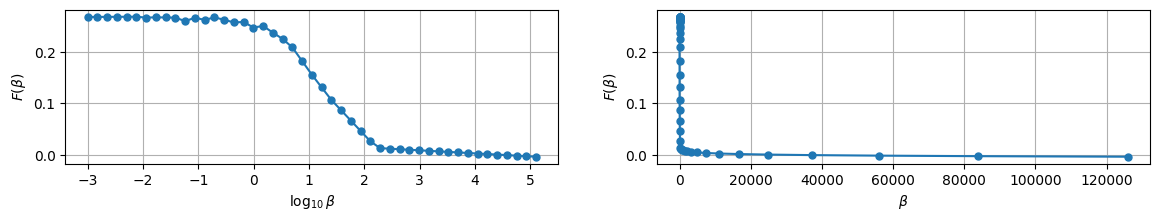

In [198]:
# b_arr = torch.tensor(lse_data['b_arr'], dtype=torch.float32)
# len_Darray = torch.tensor(lse_data['len_Darray'], dtype=torch.float32)
io_scale = lse_data['io_scale']
b_min = 0.001
b_max = 100000
b_grow = 1.5
b_array = utils.createBetaArray(b_min, b_max, b_grow).to(device)
drone_id = np.random.choice(range(num_drones))
FreeEnergy = []
log_betas = []
betas = []

s = time.time()
with torch.no_grad():
    # forward pass: no activations are saved for grad
    _, actions = vrp_net(data, mod='eval_greedy')
e = time.time()
actions.detach()

d_mins = utils.route_cost(data, actions)[drone_id:drone_id+1]
Fmin_est = area_approx_F(d_mins, D_max_range=1.0, beta=b_min, printCalculations=False)
beta=b_min

for beta in b_array:

    torch.cuda.empty_cache()
    In = torch.tensor([
        Fmin_est.to(device),
        io_scale*d_mins,
        torch.log(torch.tensor([beta]))/torch.log(torch.tensor([10.0])).to(device)
    ])
    log_betas.append(In[2].detach().numpy())
    betas.append(10**In[2].detach().numpy())
    Out = lse_net(In)/io_scale - 0*(1/beta * torch.log(n_drone_routes[drone_id,0])).to(device)
    FreeEnergy.append(Out[0].detach().numpy())
    

plt.figure(figsize=(14,2))

plt.subplot(1,2,1)
plt.plot(log_betas, FreeEnergy - d_mins.detach().numpy(), marker='.', markersize=10)
# plt.plot(log_betas, d_mins.detach().numpy() * np.ones(len(betas)), marker='.', markersize=5)
plt.xlabel(rf'$\log_{{10}}\beta$')
plt.ylabel(rf'$F(\beta)$')
plt.grid()

plt.subplot(1,2,2)
plt.plot(betas, FreeEnergy - d_mins.detach().numpy(), marker='.', markersize=10)
# plt.plot(betas, d_mins.detach().numpy() * np.ones(len(betas)), marker='.', markersize=5)
plt.xlabel(rf'$\beta$')
plt.ylabel(rf'$F(\beta)$')
plt.grid()
plt.show()

### Perform annealing. At each beta, the free energy is optimized by computing the gradients using backpropagation.

In [199]:
num_epochs = 1000;
optimizer = optim.Adam([F_base], lr=1e-3)
# b_arr = torch.tensor(lse_data['b_arr'], dtype=torch.float32)
# len_Darray = torch.tensor(lse_data['len_Darray'], dtype=torch.float32)
io_scale = lse_data['io_scale']
b_min = 1e-3
b_max = 1e-3
b_grow = 2
b_array = utils.createBetaArray(b_min, b_max, b_grow).to(device)
torch.autograd.set_detect_anomaly(True)
# beta=b_min
for beta in b_array:
    print(f"beta:{beta:.3e}")
    for epoch in range(num_epochs):
        s = time.time()
        with torch.no_grad():
            # forward pass: no activations are saved for grad
            _, actions = vrp_net(data, mod='eval_greedy')
        e = time.time()
        actions.detach()
        d_mins = utils.route_cost(data, actions)
        Fmin_est_tensor = area_approx_F(d_mins, D_max_range=1.0, beta=b_min, printCalculations=False)

        torch.cuda.empty_cache()

        In = torch.cat((
            Fmin_est_tensor.view(-1,1),
            io_scale*d_mins.view(-1,1), 
            torch.ones((num_drones,1)).to(device)*torch.log(torch.tensor([beta]))/torch.log(torch.tensor([10.0])).to(device).to(device)), axis=1) #, torch.ones((num_drones,1)).to(device)*b_min.to(device)),axis=1)

        Out = lse_net(In)/io_scale
        FreeEnergy = torch.mean(Out)
        
        # print(torch.norm(data))
        optimizer.zero_grad()
        FreeEnergy.backward()
        optimizer.step()
        # perturb and update facility location data for each drone
        std1 = torch.tensor([[0.05,0.05]]).repeat(nd_per_cluster,1).unsqueeze(1).to(device)
        with torch.no_grad():
            F_base += torch.normal(mean=torch.zeros(1,num_facilities,dim_), std=0.0001*torch.ones(1,num_facilities,dim_)).to(device)
        # print(F_base)
        F_locs = F_base.expand(num_drones, -1, -1)
        # print(F_locs)
        data = torch.cat((START_locs, F_locs, END_locs), dim=1)
        if epoch % 10 == 0 or epoch == num_epochs-1:
            print(f"\tEpoch: {epoch}\tVRP_runtime: {e-s:.2f}s\tFreeEnergy: {FreeEnergy:.2f}\tF_Grad: {torch.max(torch.abs(F_base.grad)):.3e}\td_min_mean: {torch.mean(d_mins):.2f}")
    # update annealing parameter
    beta = beta * b_grow
    


beta:1.000e-03
	Epoch: 0	VRP_runtime: 0.01s	FreeEnergy: 0.76	F_Grad: 4.980e-01	d_min_mean: 0.52
	Epoch: 10	VRP_runtime: 0.00s	FreeEnergy: 0.76	F_Grad: 5.004e-01	d_min_mean: 0.49
	Epoch: 20	VRP_runtime: 0.00s	FreeEnergy: 0.74	F_Grad: 4.102e-01	d_min_mean: 0.48
	Epoch: 30	VRP_runtime: 0.00s	FreeEnergy: 0.74	F_Grad: 2.526e-01	d_min_mean: 0.48
	Epoch: 40	VRP_runtime: 0.00s	FreeEnergy: 0.73	F_Grad: 2.294e-01	d_min_mean: 0.46
	Epoch: 50	VRP_runtime: 0.00s	FreeEnergy: 0.72	F_Grad: 2.154e-01	d_min_mean: 0.45
	Epoch: 60	VRP_runtime: 0.00s	FreeEnergy: 0.72	F_Grad: 2.016e-01	d_min_mean: 0.44
	Epoch: 70	VRP_runtime: 0.00s	FreeEnergy: 0.71	F_Grad: 1.900e-01	d_min_mean: 0.42
	Epoch: 80	VRP_runtime: 0.00s	FreeEnergy: 0.70	F_Grad: 2.289e-01	d_min_mean: 0.41
	Epoch: 90	VRP_runtime: 0.00s	FreeEnergy: 0.69	F_Grad: 1.808e-01	d_min_mean: 0.39
	Epoch: 100	VRP_runtime: 0.00s	FreeEnergy: 0.69	F_Grad: 1.464e-01	d_min_mean: 0.38
	Epoch: 110	VRP_runtime: 0.00s	FreeEnergy: 0.69	F_Grad: 2.399e-01	d_min_mean: 0.37


# Plotting some results

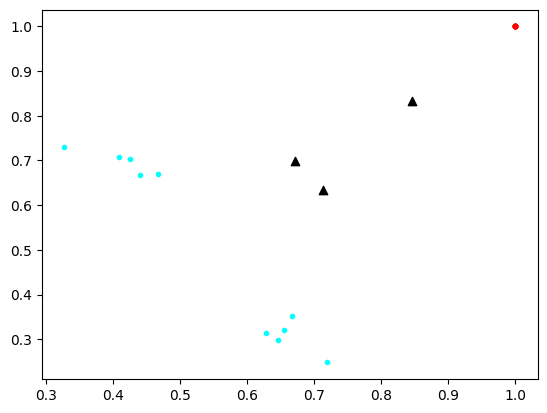

In [200]:
start_locs = START_locs.squeeze(1).cpu().numpy()
plt.scatter(start_locs[:,0],start_locs[:,1],color='cyan',marker='.')
end_locs = END_locs.squeeze(1).cpu().numpy()
plt.scatter(end_locs[:,0],end_locs[:,1],color='red',marker='.')
f_locs = F_base.squeeze(0).detach().cpu().numpy()
plt.scatter(f_locs[:,0],f_locs[:,1],color='black',marker='^')